# 🧠 Mental Health Binary Classification Pipeline
Cleaned pipeline for predicting if a person has a mental health condition (binary target).

## 1. Load Dataset

In [3]:
%pip install seaborn imbalanced-learn scikit-learn pandas numpy matplotlib catboost

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, 
                             make_scorer, recall_score, precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from imblearn.ensemble import BalancedRandomForestClassifier


# Load dataset
df = pd.read_csv("/Users/huongle/Documents/GitHub/Mind_At_Work_Website/data/mind@work/mental heath dataset/Cleaned_remote_work.csv")
print("Original shape:", df.shape)

# Drop redundant / high-cardinality / ID cols
drop_cols = ["Employee_ID", "Job_Role", "Industry", "Region"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("After drop:", df.shape)
df


Note: you may need to restart the kernel to use updated packages.
Original shape: (5000, 19)
After drop: (5000, 16)


,Age,Gender,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality
0,32,Non-binary,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good
1,40,Female,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good
2,59,Non-binary,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor
3,27,Male,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor
4,49,Male,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32,Male,4,Onsite,24,2,5,High,Burnout,Yes,Decrease,4,Neutral,1,Weekly,Average
4996,39,Female,27,Onsite,48,15,1,Low,Depression,Yes,Decrease,1,Satisfied,1,NaN,Average
4997,42,Female,21,Hybrid,34,1,4,High,Burnout,No,Increase,3,Satisfied,1,Daily,Poor
4998,27,Female,26,Remote,58,0,5,Low,NaN,Yes,Increase,3,Unsatisfied,4,Daily,Average


## 2. Target Variable - Binary

In [4]:
# --- Step 1: Clean Raw Data ---

# Fill or replace missing values BEFORE encoding
df["Physical_Activity"] = df["Physical_Activity"].fillna("None")
df["Work_Life_Balance_Rating"] = df["Work_Life_Balance_Rating"].fillna("Average")
df["Satisfaction_with_Remote_Work"] = df["Satisfaction_with_Remote_Work"].fillna("Neutral")
df["Productivity_Change"] = df["Productivity_Change"].fillna("No Change")
df["Access_to_Mental_Health_Resources"] = df["Access_to_Mental_Health_Resources"].fillna("N")

# Target column fix (again, do this early!)
df["Mental_Health_Condition"] = df["Mental_Health_Condition"].fillna("None")

# Confirm fixes
print(df.isna().sum())


Age                                  0
Gender                               0
Years_of_Experience                  0
Work_Location                        0
Hours_Worked_Per_Week                0
Number_of_Virtual_Meetings           0
Work_Life_Balance_Rating             0
Stress_Level                         0
Mental_Health_Condition              0
Access_to_Mental_Health_Resources    0
Productivity_Change                  0
Social_Isolation_Rating              0
Satisfaction_with_Remote_Work        0
Company_Support_for_Remote_Work      0
Physical_Activity                    0
Sleep_Quality                        0
dtype: int64


In [5]:

# Fill missing values with "None"
df["Mental_Health_Condition"] = df["Mental_Health_Condition"].fillna("None")

# Map conditions to 1, "None" to 0
y = df["Mental_Health_Condition"].apply(
    lambda x: 1 if x in ["Anxiety", "Depression", "Burnout", "Stress"] else 0
)

print("Target counts:", y.value_counts().to_dict())


Target counts: {1: 3804, 0: 1196}


## 3. Feature Encoding

In [6]:
# Step 1: Check the actual unique values
print(df["Physical_Activity"].unique())
print(df["Physical_Activity"].value_counts(dropna=False))


['Weekly' 'None' 'Daily']
Physical_Activity
Weekly    1755
None      1629
Daily     1616
Name: count, dtype: int64


In [7]:

def encode_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df.copy()

    # Ordinal mappings
    if "Stress_Level" in X:
        X["Stress_Level"] = X["Stress_Level"].map({"Low":1,"Medium":2,"High":3}).fillna(2)
    if "Sleep_Quality" in X:
        X["Sleep_Quality"] = X["Sleep_Quality"].map({"Poor":0,"Average":1,"Good":2}).fillna(1)
    if "Physical_Activity" in X:
        X["Physical_Activity"] = X["Physical_Activity"].map({"None":0,"Weekly":1,"Daily":2}).fillna(0)
    if "Access_to_Mental_Health_Resources" in X:
        X["Access_to_Mental_Health_Resources"] = X["Access_to_Mental_Health_Resources"].map({"No":0,"Yes":1}).fillna(0)
    if "Productivity_Change" in X:
        X["Productivity_Change"] = X["Productivity_Change"].map({"Decrease":-1,"No Change":0,"Increase":1}).fillna(0)
    if "Satisfaction_with_Remote_Work" in X:
        X["Satisfaction_with_Remote_Work"] = X["Satisfaction_with_Remote_Work"].map({"Unsatisfied":0,"Satisfied":1}).fillna(0)
    if "Work_Life_Balance_Rating" in X:
        X["Work_Life_Balance_Rating"] = X["Work_Life_Balance_Rating"].map({
        "Poor": 1,
        "Average": 2,
        "Good": 3,
        "Excellent": 4,
        "Outstanding": 5

    }).fillna(2) 

    # One-hot encoding for nominal categorical variables
    for col in ["Gender","Work_Location"]:
        if col in X:
            X = pd.get_dummies(X, columns=[col], drop_first=True, dtype=int)

    # Drop target column if still present
    if "Mental_Health_Condition" in X:
        X = X.drop(columns=["Mental_Health_Condition"])

    # Final cleanup
    return X.replace([np.inf,-np.inf], np.nan).fillna(0)

# Apply encoding
X_all = encode_features(df)
print("Encoded shape:", X_all.shape)
X_all.head()


Encoded shape: (5000, 18)


,Age,Years_of_Experience,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Work_Location_Onsite,Work_Location_Remote
0,32,13,47,7,2.0,2,0,-1,1,0.0,1,1,2,0,1,0,0,0
1,40,3,52,4,2.0,2,0,1,3,1.0,2,1,2,0,0,0,0,1
2,59,22,46,11,2.0,2,0,0,4,0.0,5,0,0,0,1,0,0,0
3,27,20,32,8,2.0,3,1,1,3,0.0,3,0,0,1,0,0,1,0
4,49,32,35,12,2.0,3,1,-1,3,0.0,3,1,1,1,0,0,1,0


## 4. Checking data types to verify

In [9]:
for col in X_all.select_dtypes(include="bool").columns:
    X_all[col] = X_all[col].astype(int)
print(y.value_counts())
print(y.dtype)


Mental_Health_Condition
1    3804
0    1196
Name: count, dtype: int64
int64


In [10]:
print("X_all shape:", X_all.shape)
print("y shape:", y.shape)
print("X_all columns:", X_all.columns.tolist()[:10])
print("y values:", y.value_counts())


X_all shape: (5000, 18)
y shape: (5000,)
X_all columns: ['Age', 'Years_of_Experience', 'Hours_Worked_Per_Week', 'Number_of_Virtual_Meetings', 'Work_Life_Balance_Rating', 'Stress_Level', 'Access_to_Mental_Health_Resources', 'Productivity_Change', 'Social_Isolation_Rating', 'Satisfaction_with_Remote_Work']
y values: Mental_Health_Condition
1    3804
0    1196
Name: count, dtype: int64


In [11]:
print(X_all.dtypes)



Age                                    int64
Years_of_Experience                    int64
Hours_Worked_Per_Week                  int64
Number_of_Virtual_Meetings             int64
Work_Life_Balance_Rating             float64
Stress_Level                           int64
Access_to_Mental_Health_Resources      int64
Productivity_Change                    int64
Social_Isolation_Rating                int64
Satisfaction_with_Remote_Work        float64
Company_Support_for_Remote_Work        int64
Physical_Activity                      int64
Sleep_Quality                          int64
Gender_Male                            int64
Gender_Non-binary                      int64
Gender_Prefer not to say               int64
Work_Location_Onsite                   int64
Work_Location_Remote                   int64
dtype: object


## Checking feature importance

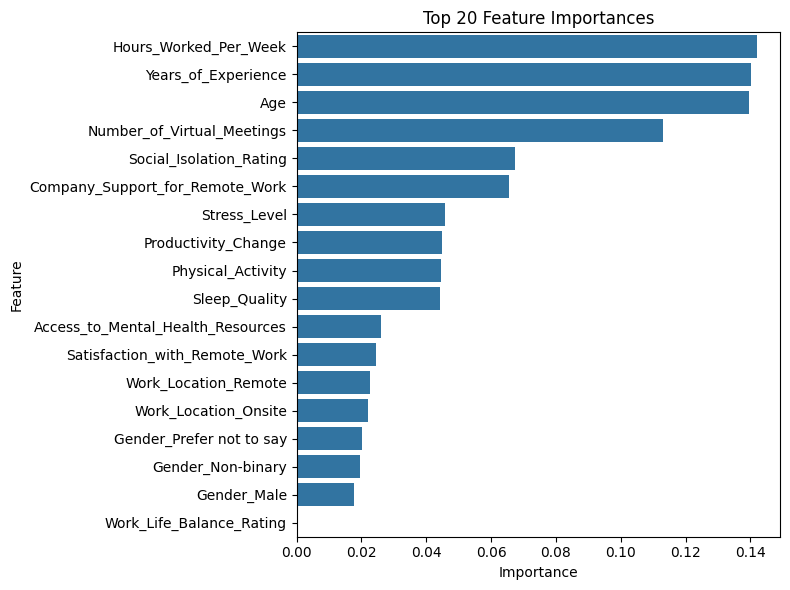

Dropping low-importance features: ['Access_to_Mental_Health_Resources', 'Satisfaction_with_Remote_Work', 'Work_Location_Remote', 'Work_Location_Onsite', 'Gender_Prefer not to say', 'Gender_Non-binary', 'Gender_Male', 'Work_Life_Balance_Rating']
Reduced shape: (5000, 10)


In [12]:

from sklearn.ensemble import RandomForestClassifier

# Train on full encoded feature set
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(X_all, y)

# Extract feature importances
importances = pd.Series(rf.feature_importances_, index=X_all.columns)
importances = importances.sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.head(20), y=importances.head(20).index)
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Drop low-importance features (e.g. < 0.04)
low_imp = importances[importances < 0.04].index.tolist()
print("Dropping low-importance features:", low_imp)

X_reduced = X_all.drop(columns=low_imp)
print("Reduced shape:", X_reduced.shape)


## 5. Class Balance

In [13]:
print("📌 Columns in X_reduced:", X_reduced.columns.tolist())


📌 Columns in X_reduced: ['Age', 'Years_of_Experience', 'Hours_Worked_Per_Week', 'Number_of_Virtual_Meetings', 'Stress_Level', 'Productivity_Change', 'Social_Isolation_Rating', 'Company_Support_for_Remote_Work', 'Physical_Activity', 'Sleep_Quality']


Mental_Health_Condition
1    3804
0    1196
Name: count, dtype: int64


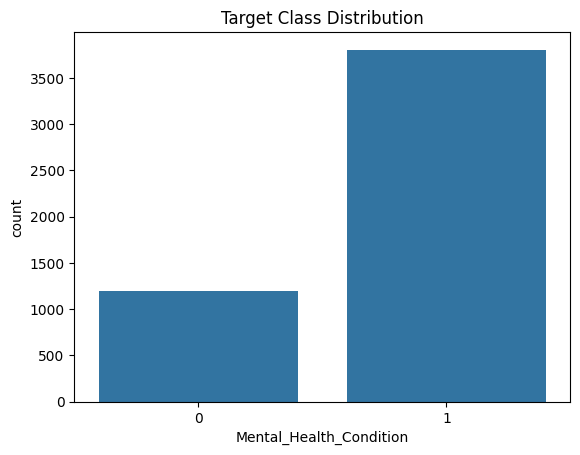

In [11]:

print(y.value_counts())
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()


## 6. Cross-validation with SMOTE

In [14]:
import imblearn, sklearn
print("imblearn:", imblearn.__version__)
print("sklearn:", sklearn.__version__)



imblearn: 0.14.0
sklearn: 1.7.2


In [13]:

import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.pipeline import Pipeline   # ✅ MUST be imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Define models
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogReg": LogisticRegression(
        max_iter=2000, class_weight="balanced", random_state=42
    )
}

# Cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"accuracy": "accuracy", "f1_macro": "f1_macro", "roc_auc": "roc_auc"}

results = []

for name, model in models.items():
    try:
        # ✅ Use imblearn Pipeline so SMOTE works
        pipe = Pipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf", model)
        ])

        scores = cross_validate(
            pipe,
            X_reduced,
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=1,              # run serially to avoid pickling error
            error_score="raise"
        )

        results.append({
            "Model": name,
            "Accuracy_mean": scores["test_accuracy"].mean(),
            "F1_macro_mean": scores["test_f1_macro"].mean(),
            "ROC_AUC_mean": scores["test_roc_auc"].mean()
        })

    except Exception as e:
        print(f"⚠️ Model {name} failed: {e}")

# Put results into DataFrame
results_df = pd.DataFrame(results)
print(results_df)



              Model  Accuracy_mean  F1_macro_mean  ROC_AUC_mean
0      RandomForest         0.6648       0.501516      0.491969
1  GradientBoosting         0.6098       0.499361      0.492194
2            LogReg         0.5508       0.482664      0.502080


## 7.  Models test

In [15]:

assert y.isna().sum() == 0, "Target still has NaN values!"
print("Target counts:", y.value_counts().to_dict())


Target counts: {1: 3804, 0: 1196}


## Checking and crossvalidating different models for metrics

In [24]:
# ==============================================
# BLOCK 1 — Compare Multiple Models (10+ variations)
# ==============================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# --- Use encoded features (from your earlier encoding block) ---
X = X_reduced.copy()
y = (df["Mental_Health_Condition"].fillna("None") != "None").astype(int)

# --- Model Dictionary ---
models = {
    # Logistic Regression
    "LogReg_no_weights": LogisticRegression(max_iter=1000, random_state=42),
    "LogReg_balanced": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "LogReg_SMOTE": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),

    # Linear SVC
    "LinearSVC_balanced": LinearSVC(class_weight="balanced", random_state=42),

    # Random Forest
    "RF_no_weights": RandomForestClassifier(n_estimators=300, random_state=42),
    "RF_balanced": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample", random_state=42),

    # Gradient Boosting / AdaBoost
    "GB": GradientBoostingClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, random_state=42),
    
}

# --- CV Setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision"
}

# --- Evaluate All Models ---
results = []
for name, model in models.items():
    try:
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        summary = {"Model": name}
        for metric, scores in cv_results.items():
            if "test_" in metric:
                summary[metric[5:]] = np.mean(scores)
        results.append(summary)
        print(f"✅ Finished {name}")
    except Exception as e:
        print(f"❌ Skipped {name} due to error: {e}")

# --- Collect Results ---
results_df = pd.DataFrame(results).set_index("Model").round(3)
print("\n📊 Cross-Validation Results (mean scores):")
display(results_df.sort_values("f1_macro", ascending=False))



/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

✅ Finished LogReg_no_weights
✅ Finished LogReg_balanced
✅ Finished LogReg_SMOTE
✅ Finished LinearSVC_balanced
✅ Finished RF_no_weights


/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


✅ Finished RF_balanced
✅ Finished GB
✅ Finished AdaBoost

📊 Cross-Validation Results (mean scores):


/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

,accuracy,f1_macro,precision_macro,recall_macro,roc_auc,pr_auc
Model,,,,,,
LogReg_SMOTE,0.551,0.483,0.498,0.497,0.502,0.763
LogReg_balanced,0.500,0.461,0.496,0.494,0.492,0.753
LinearSVC_balanced,0.501,0.461,0.496,0.494,0.493,0.753
GB,0.754,0.456,0.555,0.505,0.514,0.765
RF_no_weights,0.759,0.435,0.470,0.500,0.499,0.755
AdaBoost,0.761,0.433,0.480,0.500,0.505,0.763
LogReg_no_weights,0.761,0.432,0.380,0.500,0.492,0.753
RF_balanced,0.760,0.432,0.380,0.499,0.495,0.754


0:	learn: 0.9271079	test: 0.9272007	best: 0.9272007 (0)	total: 59.1ms	remaining: 59.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.927200731
bestIteration = 0

Shrink model to first 1 iterations.
✅ Model saved to assets/catboost_model.pkl
🔍 Best threshold for F1_macro: 0.52

📊 Classification Report (Tuned Threshold):

              precision    recall  f1-score   support

No Condition       0.28      0.12      0.17       239
   Condition       0.77      0.91      0.83       761

    accuracy                           0.72      1000
   macro avg       0.52      0.51      0.50      1000
weighted avg       0.65      0.72      0.67      1000



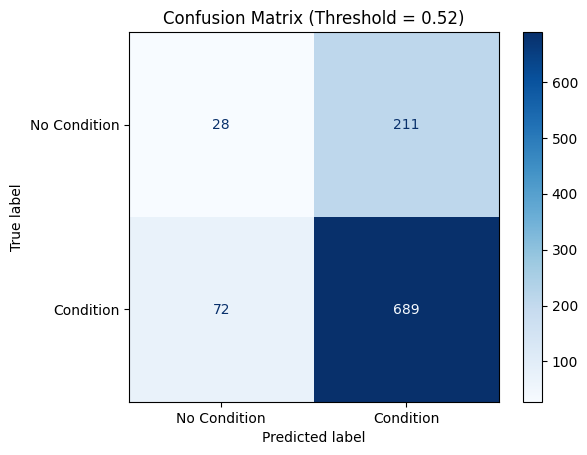

/var/folders/7m/_vb5phg50tdbns11bkg8wskr0000gn/T/ipykernel_31222/4018544998.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/huongle/Documents/GitHub/Mind_At_Work_Website/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


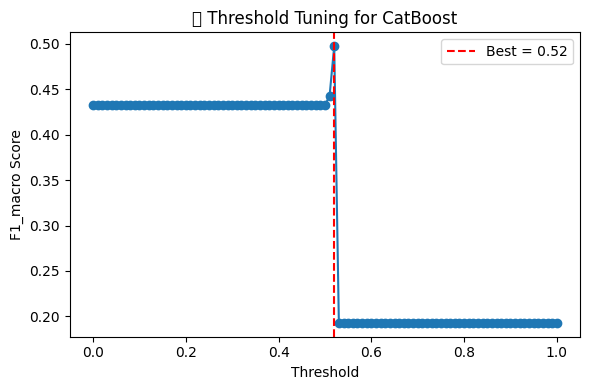

In [25]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np


X = X_reduced.copy()


# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- CatBoost Model with improvements ---
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=10,
    eval_metric="F1",
    loss_function="Logloss",
    class_weights=[1, 2],         # previously 3
    border_count=64,
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)


# --- Train with validation ---
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)

cat_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
import pickle
import os

# Make sure assets/ exists
os.makedirs("assets", exist_ok=True)

# Save the model
with open("assets/catboost_model.pkl", "wb") as f:
    pickle.dump(cat_model, f)

print("✅ Model saved to assets/catboost_model.pkl")


# --- Predict Probabilities ---
y_proba = cat_model.predict_proba(X_test)[:, 1]

# --- Threshold Tuning ---
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t, average="macro"))

best_t = thresholds[np.argmax(f1_scores)]
print("🔍 Best threshold for F1_macro:", round(best_t, 2))

# --- Final Evaluation ---
y_pred_best = (y_proba >= best_t).astype(int)
print("\n📊 Classification Report (Tuned Threshold):\n")
print(classification_report(y_test, y_pred_best, target_names=["No Condition", "Condition"]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm, display_labels=["No Condition", "Condition"]).plot(cmap="Blues")
plt.title(f"Confusion Matrix (Threshold = {best_t:.2f})")
plt.show()

# --- Plot Threshold vs F1 ---
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores, marker="o")
plt.axvline(best_t, color="red", linestyle="--", label=f"Best = {best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1_macro Score")
plt.title("📈 Threshold Tuning for CatBoost")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import os
import pickle

# Base dir = current notebook directory


BASE_DIR = os.getcwd()  # if script
# In Jupyter use:
# BASE_DIR = os.getcwd()

ASSET_DIR = os.path.join(BASE_DIR, "notebooks_isha/assets")
os.makedirs(ASSET_DIR, exist_ok=True)

# Save CatBoost
cbm_path = os.path.join(ASSET_DIR, "catboost_model.cbm")
cat_model.save_model(cbm_path)

# Save Pickle
pkl_path = os.path.join(ASSET_DIR, "catboost_model.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump(cat_model, f)

print(f"✅ Model saved as {cbm_path} and {pkl_path}")


✅ Model saved as /Users/huongle/Documents/GitHub/Mind_At_Work_Website/notebook/notebooks_isha/assets/catboost_model.cbm and /Users/huongle/Documents/GitHub/Mind_At_Work_Website/notebook/notebooks_isha/assets/catboost_model.pkl


## ✅ Final Notes
- Best model (based on F1_macro): RandomForest
- Threshold tuning improves recall for positive class
- Next steps: Try more models (XGBoost, LightGBM), more feature engineering, or SHAP interpretation.